In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json
from myGenerator import DataGenerator
import CustomLayers as cl

### Carga de datos

In [3]:
train = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanTrain.plk")
val = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanVal.plk")
# test = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanTest.plk")
# docDict = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/UniquePanDocs.plk")

In [4]:
def spectraLoader(inputPath: str) -> pd.DataFrame:
    df = pd.DataFrame()
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            lineDf = pd.DataFrame({'id':jsonline['id'], 'spectra':[np.array(jsonline['spectra'])]})
            df = pd.concat([df, lineDf])
    df = df.reset_index(drop=True)

    return df

In [5]:
full_spectra = spectraLoader("pan22-authorship-verification-training-dataset/particionesXid/FullSpectra.jsonl")

In [6]:
def loadLabels(inputPath:str, labelDict:dict) -> dict:
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            labelDict[jsonline['id']] = 1 if jsonline['value'] else 0
        
    return labelDict

In [7]:
labels = dict()
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/train_truth.jsonl',labels)
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/val_truth.jsonl',labels)

In [8]:
print("Instances: {}".format((train.shape[0] + val.shape[0])/2))
print("Labels: ",len(labels))

Instances: 16486.0
Labels:  16486


In [9]:
labels["a09fdc6b-ed15-48c5-9d2e-572f989b9b4500000"]

0

In [10]:
partition = {'train': train.id.unique().tolist(), 'validation': val.id.unique().tolist()}

In [11]:
print("Train: ", len(partition['train']))
print("Validation: ", len(partition['validation']))
print("Total: ", len(partition['train'])+len(partition['validation']))

Train:  15732
Validation:  754
Total:  16486


In [12]:
train.loc[train.id == 'a'].merge(full_spectra, left_on='idtext', right_on='id').spectra


Series([], Name: spectra, dtype: object)

### Definición de la arquitectura de red siamesa

In [ ]:
# Modelo de red siamesa utilizando una red residual y un perceptron multicapa

x1 = tf.keras.Input(shape=(1200,), name="Input_1")
x2 = tf.keras.Input(shape=(1200,), name="Input_2")

# Batch normalization
bn_layer = tf.keras.layers.BatchNormalization(name="Batch_normalization")
x1 = bn_layer(x1)
x2 = bn_layer(x2)

# Gaussian noise
gaussian_noise_layer = tf.keras.layers.GaussianNoise(1.0, name="Gaussian_noise")
x1 = gaussian_noise_layer(x1)
x2 = gaussian_noise_layer(x2)

# Dropout
dropout_layer = tf.keras.layers.Dropout(0.4, name="Dropout_1")
x1 = dropout_layer(x1)
x2 = dropout_layer(x2)

# Residual network

substract = lambda x: x[0] - x[1]
residual = tf.keras.layers.Lambda(function=substract, output_shape=lambda x: x[0], name='residual')
residual = cl.ResidualLayer(name="Residual")

dense_layer_1 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_1")
o1_1 = dense_layer_1(x1)
o1_2 = dense_layer_1(x2)

dense_layer_2 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_2")
o2_1 = dense_layer_2(o1_1)
o2_2 = dense_layer_2(o1_2)

# Residual layer
dense_layer_3 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_3")
o3_1 = dense_layer_3(residual([o1_1, o2_1]))
o3_2 = dense_layer_3(residual([o1_2, o2_2]))

dense_layer_4 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_4")
o4_1 = dense_layer_4(o3_1)
o4_2 = dense_layer_4(o3_2)

# Residual layer
dense_layer_5 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_5")
o5_1 = dense_layer_5(residual([o3_1, o4_1]))
o5_2 = dense_layer_5(residual([o3_2, o4_2]))

dense_layer_6 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_6")
o6_1 = dense_layer_6(o5_1)
o6_2 = dense_layer_6(o5_2)

# Residual layer
dense_layer_7 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_7")
o7_1 = dense_layer_7(residual([o5_1, o6_1]))
o7_2 = dense_layer_7(residual([o5_2, o6_2]))

dense_layer_8 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_8")
o8_1 = dense_layer_8(o7_1)
o8_2 = dense_layer_8(o7_2)

# Residual layer
dense_layer_9 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_9")
o9_1 = dense_layer_9(residual([o7_1, o8_1]))
o9_2 = dense_layer_9(residual([o7_2, o8_2]))

# Merging
# abs_substract = lambda x: tf.keras.backend.abs(x[0] - x[1])
# merge = tf.keras.layers.Lambda(function=abs_substract, output_shape=lambda x: x[0], name='merge')([o9_1,o9_2])
merge = cl.AbsoluteResidual(name="AbsoluteResidual")([o9_1,o9_2])

# MLPNN Classifier
hidden = tf.keras.layers.Dense(128, activation='relu', name="hidden_layer")(merge)
dropout_layer2 = tf.keras.layers.Dropout(0.4, name="Dropout_2")(hidden)
output = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(dropout_layer2)

model = tf.keras.Model([x1, x2], output)
model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=["binary_accuracy"])

In [13]:
# Modelo de red siamesa utilizando una red residual y un perceptron multicapa SIN CAPAS CUSTOM

x1 = tf.keras.Input(shape=(1200,), name="input_1")
x2 = tf.keras.Input(shape=(1200,), name="input_2")

# Batch normalization
# bn_layer = tf.keras.layers.BatchNormalization(name="Batch_normalization")
# x1 = bn_layer(x1)
# x2 = bn_layer(x2)

# # Gaussian noise
# gaussian_noise_layer = tf.keras.layers.GaussianNoise(1.0, name="Gaussian_noise")
# x1 = gaussian_noise_layer(x1)
# x2 = gaussian_noise_layer(x2)

# # Dropout
# dropout_layer = tf.keras.layers.Dropout(0.4, name="Dropout_1")
# x1 = dropout_layer(x1)
# x2 = dropout_layer(x2)

# Residual network
dense_layer_1 = tf.keras.layers.Dense(256, activation='relu', name="resdense_1")
o1_1 = dense_layer_1(x1)
o1_2 = dense_layer_1(x2)

dense_layer_2 = tf.keras.layers.Dense(256, activation='relu', name="resdense_2")
o2_1 = dense_layer_2(o1_1)
o2_2 = dense_layer_2(o1_2)

# Residual layer
dense_layer_3 = tf.keras.layers.Dense(256, activation='relu', name="resdense_3")
o3_1 = dense_layer_3(tf.subtract(o1_1, o2_1))
o3_2 = dense_layer_3(tf.subtract(o1_2, o2_2))

# dense_layer_4 = tf.keras.layers.Dense(256, activation='relu', name="resdense_4")
# o4_1 = dense_layer_4(o3_1)
# o4_2 = dense_layer_4(o3_2)

# # Residual layer
# dense_layer_5 = tf.keras.layers.Dense(256, activation='relu', name="resdense_5")
# o5_1 = dense_layer_5(tf.subtract(o3_1, o4_1))
# o5_2 = dense_layer_5(tf.subtract(o3_2, o4_2))

# dense_layer_6 = tf.keras.layers.Dense(256, activation='relu', name="resdense_6")
# o6_1 = dense_layer_6(o5_1)
# o6_2 = dense_layer_6(o5_2)

# # Residual layer
# dense_layer_7 = tf.keras.layers.Dense(256, activation='relu', name="resdense_7")
# o7_1 = dense_layer_7(tf.subtract(o5_1, o6_1))
# o7_2 = dense_layer_7(tf.subtract(o5_2, o6_2))

# dense_layer_8 = tf.keras.layers.Dense(256, activation='relu', name="resdense_8")
# o8_1 = dense_layer_8(o7_1)
# o8_2 = dense_layer_8(o7_2)

# # Residual layer
# dense_layer_9 = tf.keras.layers.Dense(256, activation='relu', name="resdense_9")
# o9_1 = dense_layer_9(tf.subtract(o7_1, o8_1))
# o9_2 = dense_layer_9(tf.subtract(o7_2, o8_2))

# Merging
# merge = tf.math.abs(tf.subtract(o9_1,o9_2))
merge = tf.math.abs(tf.subtract(o3_1,o3_2))

# MLPNN Classifier
hidden = tf.keras.layers.Dense(128, activation='relu', name="hidden_layer")(merge)
# dropout_layer2 = tf.keras.layers.Dropout(0.4, name="Dropout_2")(hidden)
output = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(hidden)#(dropout_layer2)

model = tf.keras.Model([x1, x2], output)
model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=["binary_accuracy"])

2022-05-17 16:53:47.188453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:53:47.210492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:53:47.210604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:53:47.210991: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
x1 = tf.keras.Input(shape=(1200,), name="Input_1")
x2 = tf.keras.Input(shape=(1200,), name="Input_2")

hidden1 = tf.keras.layers.Dense(128, activation='relu', name="hidden_layer1")
h1 = hidden1(x1)
h2 = hidden1(x2)

# Dropout
dropout_layer = tf.keras.layers.Dropout(0.4, name="Dropout_1")
d1 = dropout_layer(h1)
d2 = dropout_layer(h2)

# merge = cl.AbsoluteResidual(name="AbsoluteResidual")([o9_1,o9_2])
merge = tf.subtract(d1,d2, name="merge")

# MLPNN Classifier
hidden2 = tf.keras.layers.Dense(128, activation='relu', name="hidden_layer2")(merge)
dropout_layer2 = tf.keras.layers.Dropout(0.4, name="Dropout_2")(hidden2)
output = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(dropout_layer2)

model = tf.keras.Model([x1, x2], output)
model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=["binary_accuracy"])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1200)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1200)]       0           []                               
                                                                                                  
 resdense_1 (Dense)             (None, 256)          307456      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 resdense_2 (Dense)             (None, 256)          65792       ['resdense_1[0][0]',         

### Entrenamiento de red siamesa

In [15]:
print("train: ", train.shape[0])
print("test: ", val.shape[0])

train:  31464
test:  1508


In [16]:
print("train: ", train.id.unique().size)
print("test: ", val.id.unique().size)

train:  15732
test:  754


In [17]:
# Parameters
params = {'dim': (1200,),
            'batch_size': 32,
            'shuffle': True}

In [18]:
# Generators
training_generator = DataGenerator(partition['train'], train, labels, full_spectra, **params)
validation_generator = DataGenerator(partition['validation'], val, labels, full_spectra, **params)

In [21]:
tf.test.gpu_device_name()

'/device:GPU:0'

2022-05-17 16:58:01.179570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:58:01.179714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:58:01.179793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:58:01.179903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:58:01.179991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [22]:
# Train model on dataset
with tf.device('/device:GPU:0'):
    history = model.fit(x=training_generator,
                        validation_data=validation_generator,
                        # use_multiprocessing=True,
                        # workers=4,
                        epochs=100,
                        verbose=1)

Epoch 1/100


2022-05-17 16:58:16.700110: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


491/491 [==============================] - 29s 56ms/step - loss: 1.3511 - binary_accuracy: 0.5527 - val_loss: 0.7614 - val_binary_accuracy: 0.5177
Epoch 2/100
491/491 [==============================] - 27s 56ms/step - loss: 0.6716 - binary_accuracy: 0.5960 - val_loss: 0.7708 - val_binary_accuracy: 0.5082
Epoch 3/100
491/491 [==============================] - 27s 56ms/step - loss: 0.6849 - binary_accuracy: 0.5294 - val_loss: 0.7258 - val_binary_accuracy: 0.4837
Epoch 4/100
491/491 [==============================] - 27s 56ms/step - loss: 0.6811 - binary_accuracy: 0.5146 - val_loss: 0.7489 - val_binary_accuracy: 0.4946
Epoch 5/100
491/491 [==============================] - 28s 56ms/step - loss: 0.6799 - binary_accuracy: 0.5129 - val_loss: 0.7834 - val_binary_accuracy: 0.4905
Epoch 6/100
491/491 [==============================] - 27s 56ms/step - loss: 0.6858 - binary_accuracy: 0.5128 - val_loss: 0.6909 - val_binary_accuracy: 0.5014
Epoch 7/100
491/491 [==============================] - 27s

In [23]:
model.save('models/SiameseNetwork-1')

2022-05-17 17:49:21.506740: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/SiameseNetwork-1/assets


### Resultados del entrenamiento

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [25]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [26]:
acc = pd.DataFrame({'accuracy':history.history['binary_accuracy'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
acc = pd.concat([acc, pd.DataFrame({'accuracy':history.history['val_binary_accuracy'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)
loss = pd.DataFrame({'loss':history.history['loss'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
loss = pd.concat([loss, pd.DataFrame({'loss':history.history['val_loss'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)

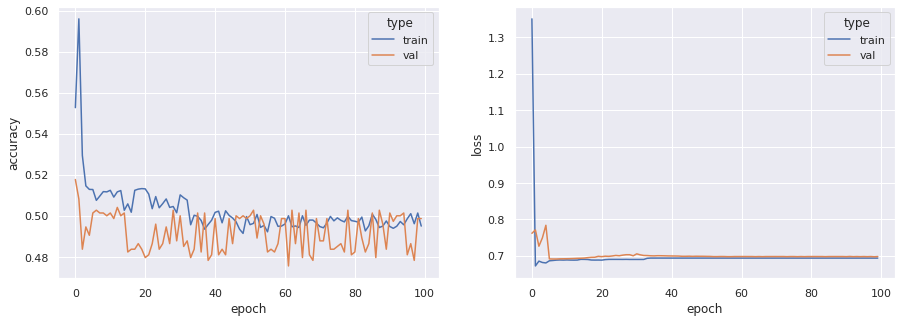

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(x='epoch', y='accuracy', data=acc, hue='type', ax=ax[0])
sns.lineplot(x='epoch', y='loss', data=loss, hue='type', ax=ax[1])
plt.show()

In [36]:
acc.loc[acc.epoch==99]

,epoch,accuracy,type
99,99,0.494972,train
199,99,0.498641,val


In [37]:
loss.loc[loss.epoch==99]

,epoch,loss,type
99,99,0.693182,train
199,99,0.697482,val
